In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter


from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

In [3]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=False)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros((T_inbound, headings.shape[1]))), axis=0)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros((T_inbound, flow.shape[1]))), axis=0)


######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz


In [123]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [124]:
#h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms, name='h_stimulus')
headings_hz = headings*Hz
P_HEADING = PoissonGroup(N_TL2, rates=headings_hz[0,:], name='P_HEADING')

#f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms, name='h_stimulus')
flow_hz = flow*Hz
P_FLOW = PoissonGroup(N_TN2, rates=flow_hz[0,:], name='P_FLOW')

In [125]:
### CL1
CL1_neuron_params = {
    'spike_count': [0],
    'EL' : [-52 * mV],
    'Vm' : [-52 * mV],
    'EE' : [0 * mV],
    'EI' : [-80 * mV],
    'gL' : [1*10**-6 * siemens],
    'gE' : '(randn() * 1.5 + 4) * 10.*nS',
    'gI' : '(randn() * 12 + 20) * 10.*nS',
    'tauE' : [1 * ms],
    'tauI' : [1.5 * ms] # change
}

TL2_CL1_synapses_params = {
    'wE' : [600 * nS],
    'wI' : [450 * nS] # change
}

In [126]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2_source_network')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1_source_network')

P_CL1 = PoissonGroup(N_CL1, rates=CL1_spike_rates*Hz, name='P_CL1')

In [127]:
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, params=H_TL2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_HEADING_TL2')

# TL2
S_P_CL1_CL1 = nc.connect_synapses(P_CL1, G_CL1, np.eye(N_CL1), model=synapses_model, params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex, name='S_P_CL1_CL1')
#S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, np.eye(N_CL1), model=synapses_model, params=TL2_CL1_synapses_params, on_pre=synapses_eqs_in, name='S_TL2_CL1')

In [128]:
SPM_HEADING = SpikeMonitor(P_HEADING, name='SPM_HEADING')

SPM_TL2 = SpikeMonitor(G_TL2, name='SPM_TL2')
SPM_CL1 = SpikeMonitor(G_CL1, name='SPM_CL1')
SPM_P_CL1 = SpikeMonitor(P_CL1,  name='SPM_P_CL1')

In [129]:
#### Target

# Scale spike rates from rate-based CX in the right range
# transpose since log is neuron_index*time_step but we want the opposite
#CL1_stimulus = TimedArray(CL1_spike_rates*cx_log.cl1.T*Hz, dt=1.*time_step*ms)
#P_CL1_TARGET = PoissonGroup(N_CL1, rates='CL1_stimulus(t,i)')
#SPM_P_CL1_TARGET = SpikeMonitor(P_CL1_TARGET)

In [130]:
def get_agent_timestep(t, sim_time_step):
    return int((t/ms + 0.5) / sim_time_step)

@network_operation(dt=time_step*ms, when='start', order=4, name='set_rates')
def set_rates(t):
    timestep = get_agent_timestep(t, time_step)

    if t < time_step*ms:
        return
    P_HEADING.rates = headings_hz[timestep,:]
    #P_FLOW.rates = flow_hz[timestep,:]
    #P_CPU4_MEMORY.rates = CPU4_memory_stimulus[timestep,:]

In [131]:
%%time
net = Network(collect())
net.run((300)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 6. s
3.3098 s (55%) simulated in 10s, estimated 8s remaining.
5.2914 s (88%) simulated in 20s, estimated 3s remaining.
6. s (100%) simulated in 21s
CPU times: user 18.6 s, sys: 240 ms, total: 18.8 s
Wall time: 22.2 s


In [134]:
gf = metric.compute_gamma_factor(SPM_CL1, SPM_P_CL1, T_outbound*time_step*ms, 
                                     dt_=defaultclock.dt, delta=1*ms, rate_correction=True)
print(gf)

0.046470066722680864


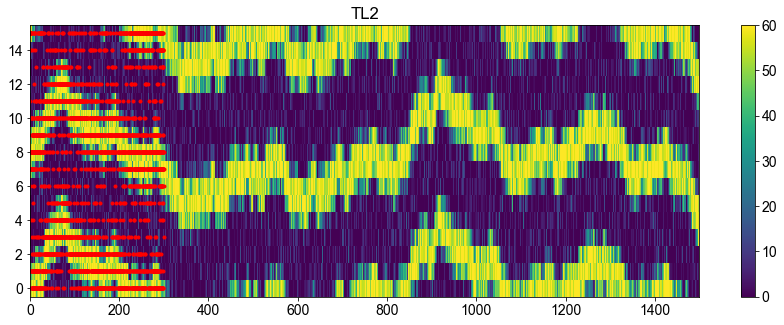

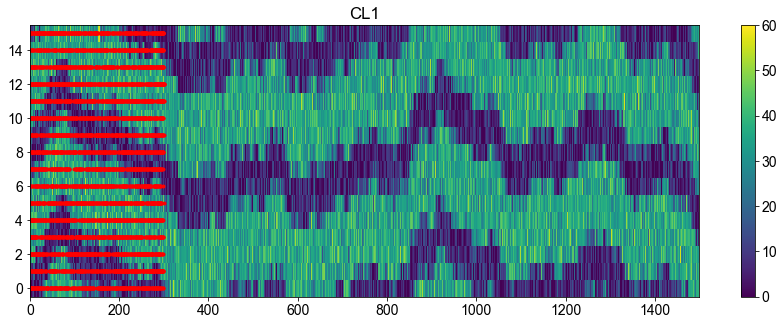

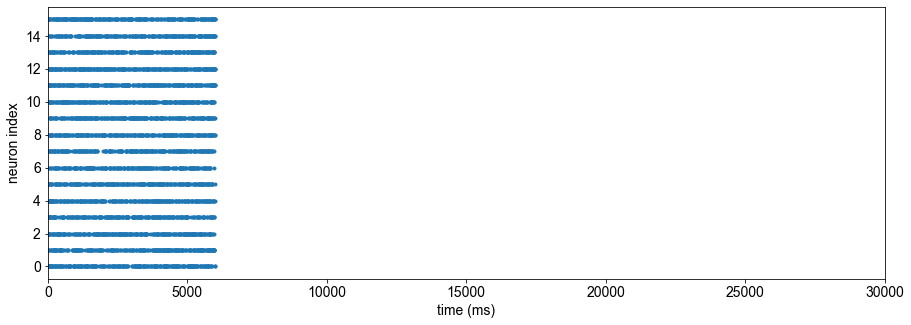

In [133]:
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tl2, 60, SPM_TL2, time_step, 
                                            title='TL2',  figsize=(15,5), xlim=[0,T_outbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cl1, 60, SPM_CL1, time_step, 
                                            title='CL1',  figsize=(15,5), xlim=[0,T_outbound])

plt.figure(figsize=(15,5))
brian_plot(SPM_P_CL1)
plt.xlim([0,T_outbound*time_step])
plt.show()